In [1]:
import torch
import torchaudio
from torch import nn
from torch.nn import functional as F
from torch.utils.data import ConcatDataset
import os
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Audio
from IPython.display import clear_output, display
import librosa
import math
import datetime
import time
import numpy as np
import ast
import random
import shutil
import soundfile as sf
from tqdm import tqdm

#Eigene Sachen
from util.util import *
from util.datasets import *
from util.audio_processing import *
import util.plot as plot
import models

In [2]:
#Konstante
SAMPLE_RATE = 16000

#Lädt Noise
dir = r"/mnt/data/source_jonas/Samples/GENERIERUNG/"
file_dataset_noise_train  = LocalFileDataset(os.path.join(dir, r"NOISES SPLITTET/RANDOM/TRAIN"), target_samplerate=SAMPLE_RATE)
file_dataset_noise_test   = LocalFileDataset(os.path.join(dir, r"NOISES SPLITTET/RANDOM/TEST"),  target_samplerate=SAMPLE_RATE)
file_dataset_foleys_train = LocalFileDataset(os.path.join(dir, r"NOISES SPLITTET/FOLEYS/TRAIN"), target_samplerate=SAMPLE_RATE)
file_dataset_foleys_test  = LocalFileDataset(os.path.join(dir, r"NOISES SPLITTET/FOLEYS/TEST"),  target_samplerate=SAMPLE_RATE)

#Lädt Voice Train
_list_file_dataset_voice_train = []
dir = r"/mnt/data/source_jonas/Samples/GENERIERUNG/EXTRACTED/"
for language in os.listdir(dir):
    
    #Path
    language_path = os.path.join(dir, language)
    
    #Lädt CSV
    df = pd.read_csv(os.path.join(language_path, "transcription.csv"))
    df["wav2vec_result"] = df["wav2vec_result"].apply(ast.literal_eval)
    df["start_in_ms"]    = df.wav2vec_result.apply(lambda json: json["start_timestamps"][0])
    df["end_in_ms"]      = df.wav2vec_result.apply(lambda json: json["end_timestamps"][-1]) 
    df["filename"]       = df["path"]
    df["language"]       = language
    df.drop(columns = "path", inplace=True)
    
    #neues Dataset
    _list_file_dataset_voice_train.append(LocalFileDataset(root_dir=os.path.join(language_path,r"clips"), data=df))

#Verbindet die Datasets
file_dataset_voice_train = ConcatDataset(_list_file_dataset_voice_train)

#Lädt Voice Test
dir = r"/mnt/data/source_jonas/Samples/GENERIERUNG/LABELD BY HAND/"
file_dataset_voice_test  = LocalFileDataset(root_dir=os.path.join(dir, r"TEST"), target_samplerate=SAMPLE_RATE, csv_file = os.path.join(dir, r"test.csv"))

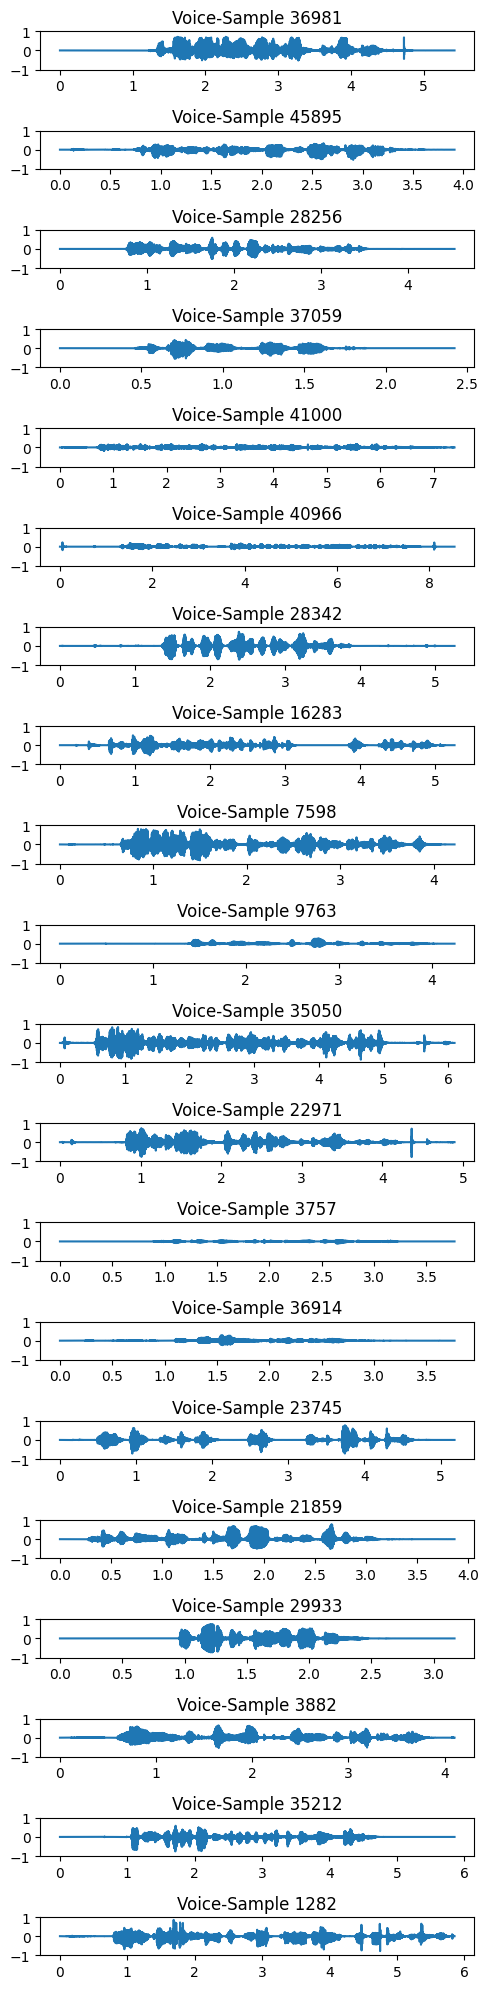

In [3]:
#Voice
_num_plots = 20

#Plot
fig = plt.figure(figsize=(5,_num_plots))

#Iterriert
for i in range(_num_plots):
    
    #Lädt random Sample
    random_idx = np.random.randint(0, len(file_dataset_voice_train))
    tensor, sr, _ = file_dataset_voice_train[ random_idx ]

    #Plottet
    ax = plt.subplot2grid((_num_plots, 1), (i, 0), fig=fig)
    plot.plot_waveform(tensor, sr = sr, ax=ax, y_axis_0dbfs_scale=True)

    ax.set_title(f"Voice-Sample {random_idx}")
    ax.set_xlabel("")
    ax.set_ylabel("")

#Plot
fig.tight_layout()

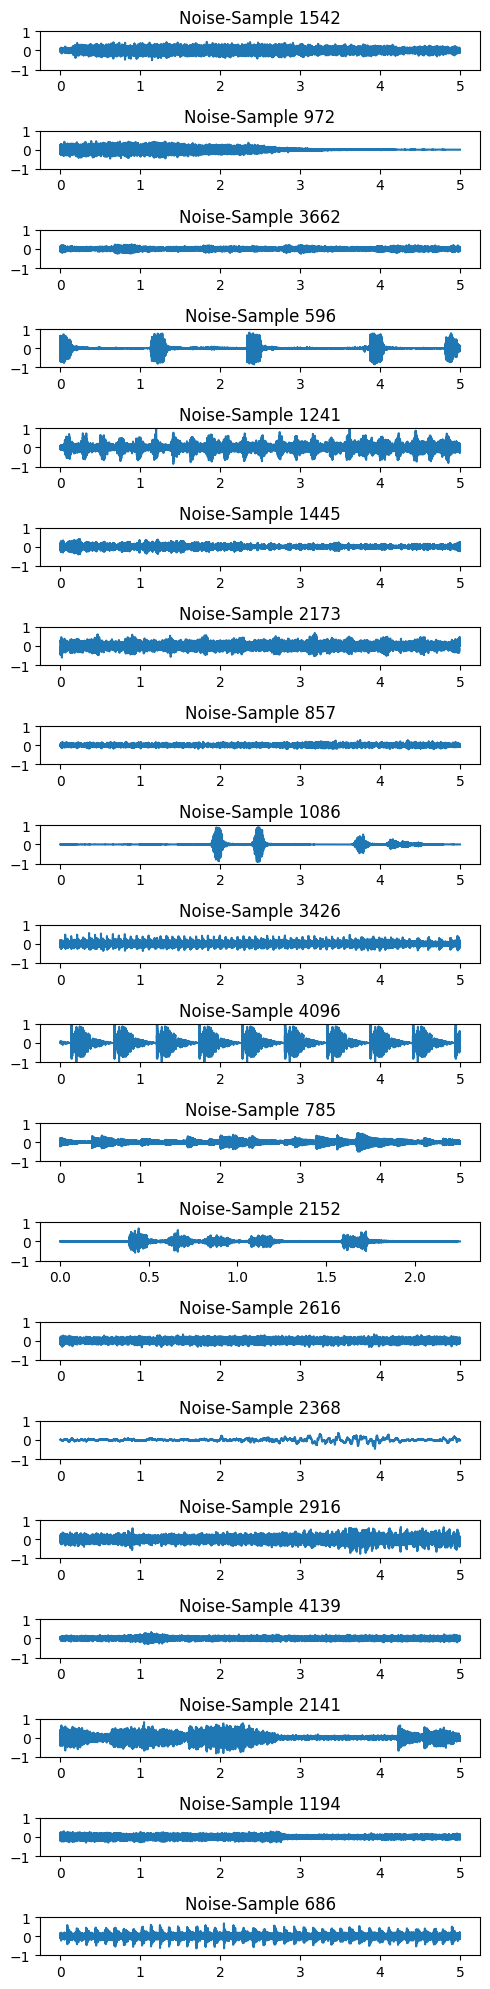

In [4]:
#Noises
_num_plots = 20

#Plot
fig = plt.figure(figsize=(5,_num_plots))

#Iterriert
for i in range(_num_plots):
    
    #Lädt random Sample
    random_idx = np.random.randint(0, len(file_dataset_noise_train))
    tensor, sr, _ = file_dataset_noise_train[ random_idx ]

    #Plottet
    ax = plt.subplot2grid((_num_plots, 1), (i, 0), fig=fig)
    plot.plot_waveform(tensor, sr = sr, ax=ax, y_axis_0dbfs_scale=True)

    ax.set_title(f"Noise-Sample {random_idx}")
    ax.set_xlabel("")
    ax.set_ylabel("")

#Plot
fig.tight_layout()

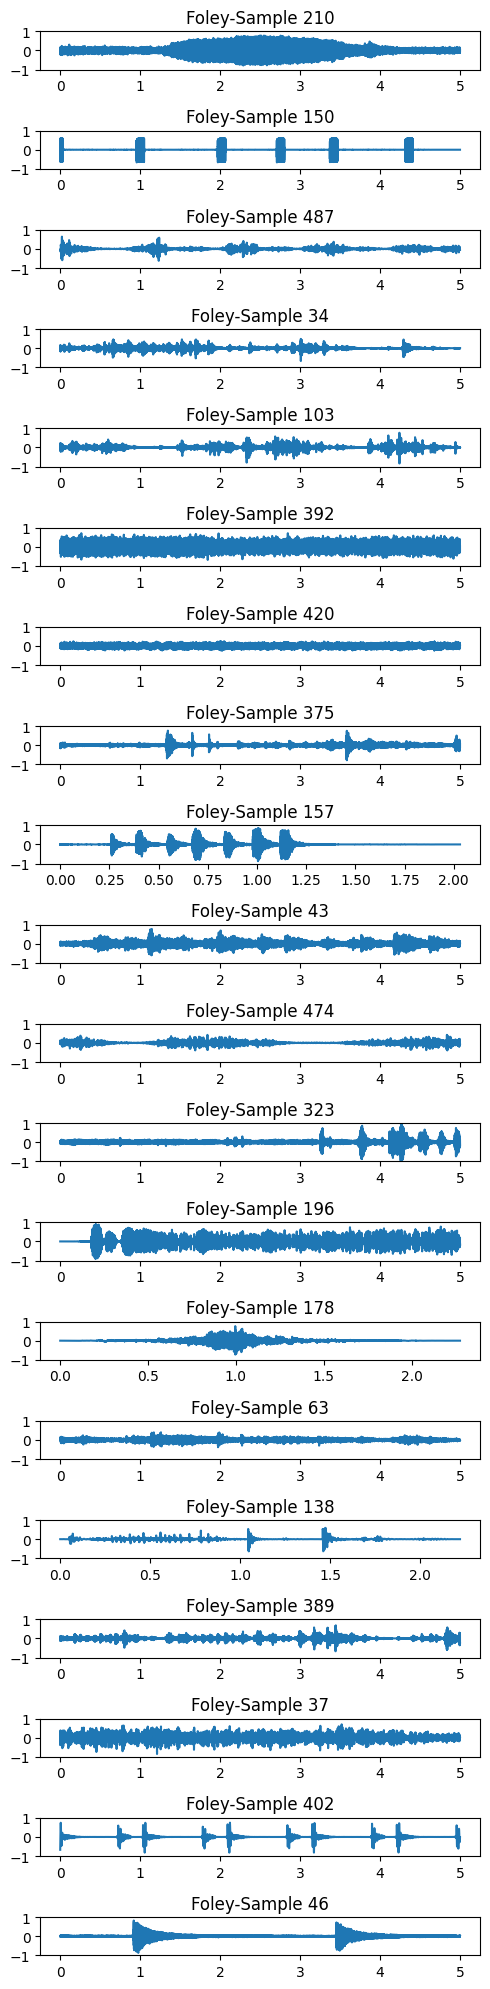

In [5]:
#Foleys
_num_plots = 20

#Plot
fig = plt.figure(figsize=(5,_num_plots))

#Iterriert
for i in range(_num_plots):
    
    #Lädt random Sample
    random_idx = np.random.randint(0, len(file_dataset_foleys_train))
    tensor, sr, _ = file_dataset_foleys_train[ random_idx ]

    #Plottet
    ax = plt.subplot2grid((_num_plots, 1), (i, 0), fig=fig)
    plot.plot_waveform(tensor, sr = sr, ax=ax, y_axis_0dbfs_scale=True)

    ax.set_title(f"Foley-Sample {random_idx}")
    ax.set_xlabel("")
    ax.set_ylabel("")

#Plot
fig.tight_layout()

In [6]:
#Funktion zum Erzeugen eines Entsprechenden Tensors
def get_voice_word2vec(tensor, sr, info):
    
    #Berechnet Start und Ende
    start_SR = librosa.time_to_samples(times = info.start_in_ms / 1000, sr=sr)
    end_SR   = librosa.time_to_samples(times = info.end_in_ms   / 1000, sr=sr)

    #Erzeugt Tensor
    result = torch.zeros_like(tensor)
    result[ start_SR : end_SR ] = 1

    return result

def get_voice_labeld(voice, sr, info):

    #Berechnet Start und Ende
    start_SR = librosa.time_to_samples(times=info.start,sr=sr)
    end_SR   = librosa.time_to_samples(times=info.end,sr=sr)

    #Erzeugt Tensor
    result = torch.zeros_like(voice)
    result[start_SR : end_SR] = 1
    
    return result

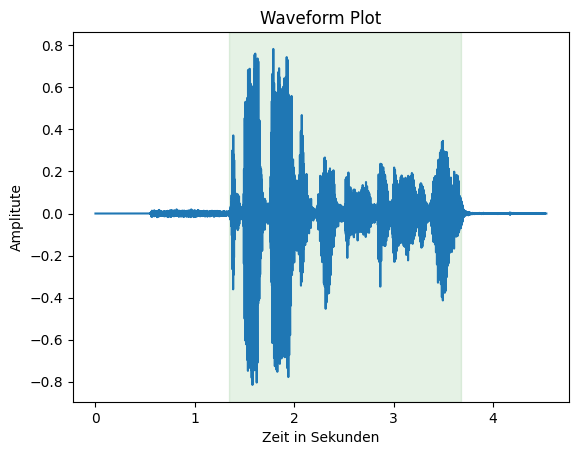

In [7]:
#Plot Ergebnisse von Wav2Vec
plot_idx = 53
tensor, sr, info = file_dataset_voice_train[plot_idx]
plot.plot_waveform_with_voice(tensor, get_voice_word2vec(tensor,sr,info), sr=sr)

In [8]:
#PARAMETER
MIN_MAX_DB_DIFFERENCE = 10

#Erebnis
_res = {}

#Iterriert über beide Datensätze
for name, dataset in { "train" : file_dataset_noise_train, "test" : file_dataset_noise_test }.items():
    
    #IDX der Samples
    background_noise = []
    other_noise      = []

    for idx, (tensor, sr, info) in enumerate(iter(dataset)):
        
        #Errechnet DB
        db_sample = db( get_samples(
            tensor,
            sample_length = librosa.time_to_samples(0.3, sr=sr),
            hop_length    = librosa.time_to_samples(0.1, sr=sr)
        ))
        
        #Fügt hinzu Wenn kein größer Lautstärke Unterschied und Konstant Noise über -30 DB
        if db_sample.lt(db_sample.max() - MIN_MAX_DB_DIFFERENCE).sum() <= 0 and db_sample.lt(-30).sum() == 0:
            background_noise.append(idx)
        
        else:
            other_noise.append(idx)


    #Gibt Anzahl der Samples aus 
    print("Anzahl Samples in ", name, ":", len(background_noise), " von ", len(dataset))

    #Erstellt neuen Datensatz
    background_noise = dataset.data.iloc[background_noise].copy().reset_index(drop=True)
    _res[name + "_background_noise"] = LocalFileDataset(dataset.root_dir, data=background_noise, target_samplerate=dataset.target_samplerate)

    #Erstellt neuen Datensatz
    other_noise = dataset.data.iloc[other_noise].copy().reset_index(drop=True)
    _res[name + "_other_noise"] = LocalFileDataset(dataset.root_dir, data=background_noise, target_samplerate=dataset.target_samplerate)

#Einfacher
file_dataset_background_noise_train = _res["train_background_noise"]
file_dataset_background_noise_trest = _res["test_background_noise"]
file_dataset_other_noise_train = _res["train_other_noise"]
file_dataset_other_noise_trest = _res["test_other_noise"]

Anzahl Samples in  train : 2429  von  4189
Anzahl Samples in  test : 998  von  1768


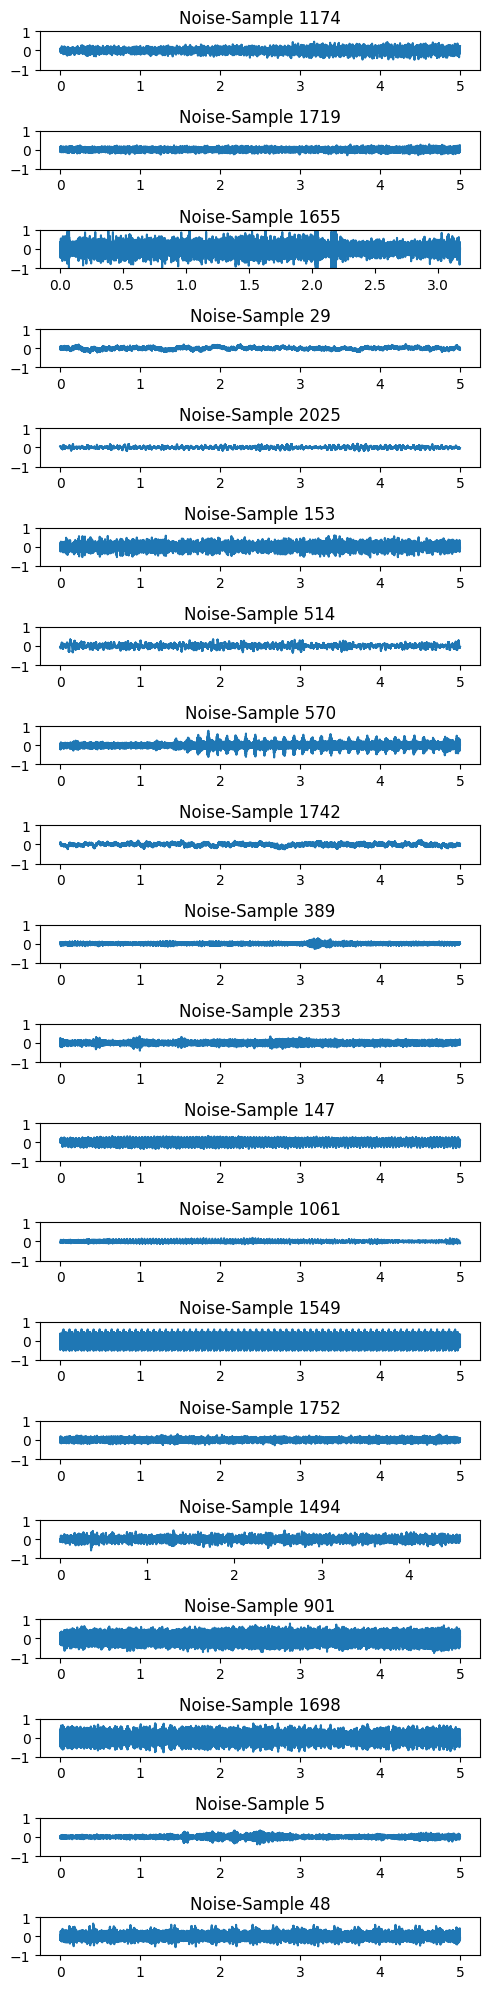

In [9]:
#Background Noises
_num_plots = 20

#Plot
fig = plt.figure(figsize=(5,_num_plots))

#Iterriert
for i in range(_num_plots):
    
    #Lädt random Sample
    random_idx = np.random.randint(0, len(file_dataset_background_noise_train))
    tensor, sr, _ = file_dataset_background_noise_train[ random_idx ]

    #Plottet
    ax = plt.subplot2grid((_num_plots, 1), (i, 0), fig=fig)
    plot.plot_waveform(tensor, sr = sr, ax=ax, y_axis_0dbfs_scale=True)

    ax.set_title(f"Noise-Sample {random_idx}")
    ax.set_xlabel("")
    ax.set_ylabel("")

#Plot
fig.tight_layout()

In [10]:
#PARAMETER
MIN_MAX_DB_DIFFERENCE = 10

#Erebnis
_res = {}

#Iterriert über beide Datensätze
for name, dataset in { "train" : file_dataset_noise_train, "test" : file_dataset_noise_test }.items():

    #IDX der Samples
    weird_noises = []
    other_noise  = []
    
    for idx, (tensor, sr, info) in enumerate(iter(dataset)):
        
        #Errechnet DB
        db_sample = db( get_samples(
            tensor,
            sample_length = librosa.time_to_samples(0.1, sr=sr),
            hop_length    = librosa.time_to_samples(0.1, sr=sr)
        ))
        
        #Fügt hinzu Wenn kein größer Lautstärke Unterschied und Konstant Noise über -30 DB
        result, count = torch.unique_consecutive(db_sample.lt(db_sample.max() - MIN_MAX_DB_DIFFERENCE), return_counts = True)
        if result.size(0) > 2 and torch.max(count) < db_sample.size(0) / 3:
            weird_noises.append(idx)
        else:
            other_noise.append(idx)


    #Gibt Anzahl der Samples aus 
    print("Anzahl Samples in ", name, ":", len(weird_noises), " von ", len(dataset))
    
    #Erstellt neuen Datensatz
    weird_noises = dataset.data.iloc[weird_noises].copy().reset_index(drop=True)
    _res[name] = LocalFileDataset(dataset.root_dir, data=weird_noises, target_samplerate=dataset.target_samplerate)

#Einfacher
file_dataset_weird_noises_train = _res["train"]
file_dataset_weird_noises_test  = _res["test"]

Anzahl Samples in  train : 642  von  4189
Anzahl Samples in  test : 261  von  1768


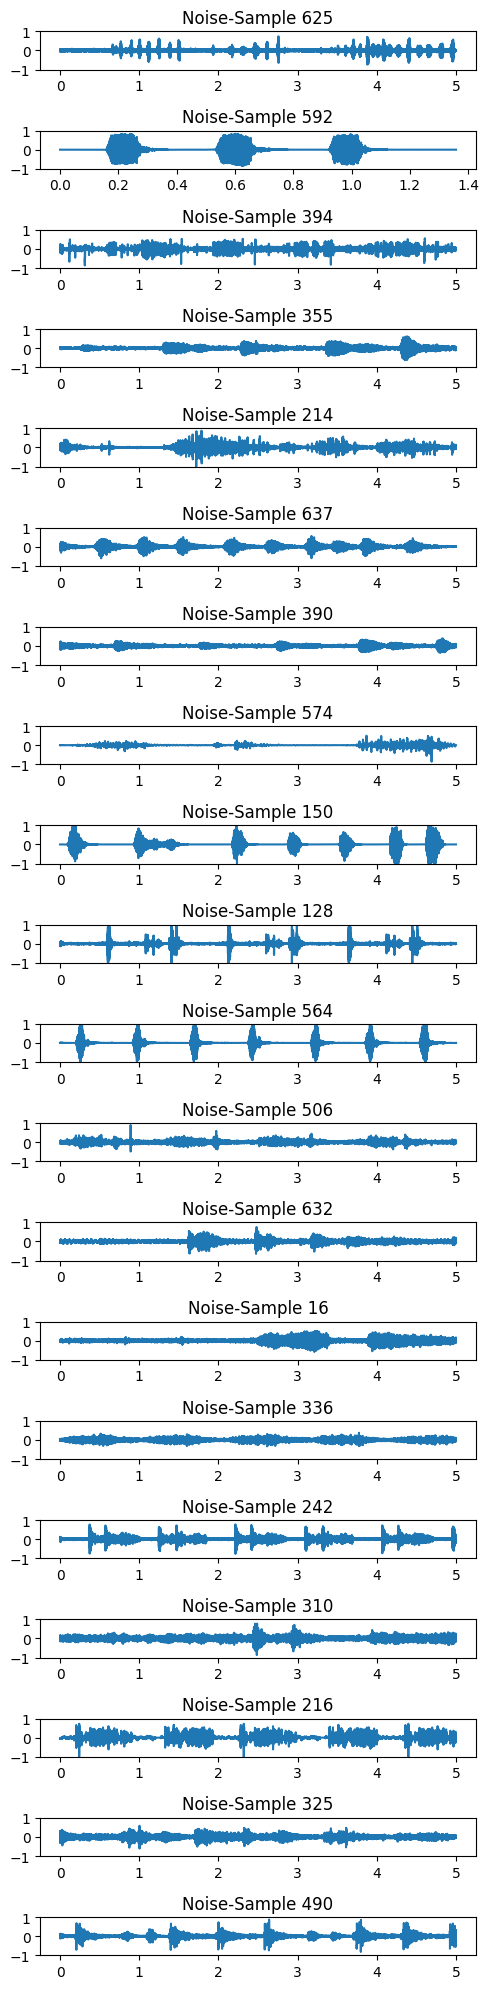

In [11]:
#Background Noises
_num_plots = 20

#Plot
fig = plt.figure(figsize=(5,_num_plots))

#Iterriert
for i in range(_num_plots):
    
    #Lädt random Sample
    random_idx = np.random.randint(0, len(file_dataset_weird_noises_train))
    tensor, sr, _ = file_dataset_weird_noises_train[ random_idx ]

    #Plottet
    ax = plt.subplot2grid((_num_plots, 1), (i, 0), fig=fig)
    plot.plot_waveform(tensor, sr = sr, ax=ax, y_axis_0dbfs_scale=True)

    ax.set_title(f"Noise-Sample {random_idx}")
    ax.set_xlabel("")
    ax.set_ylabel("")

#Plot
fig.tight_layout()

In [12]:
#Concat
file_dataset_layer_noises_train = ConcatDataset([file_dataset_weird_noises_train, file_dataset_foleys_train])
file_dataset_layer_noises_test  = ConcatDataset([file_dataset_weird_noises_test,  file_dataset_foleys_test])

In [13]:
class SampleGenerator(nn.Module):
    
    def __init__(
            self,
            no_speech_to_speech_ratio = 2,
            sn_ratio_db = 10,
            noise_edge = librosa.time_to_samples(times=0.5, sr=SAMPLE_RATE),
        ):
        super().__init__()

        #Params
        self.no_speech_to_speech_ratio = no_speech_to_speech_ratio
        self.sn_ratio_rms              = librosa.db_to_amplitude(sn_ratio_db)
        self.noise_edge                = noise_edge
        
        #Variables
        self.normalize_result          = True
    
    @torch.no_grad()
    def forward(self, waveform, noise, waveform_ground_truth):

        #Kalkuliert länge vom Ergebniss
        _ground_truth_non_zeros_idx   = waveform_ground_truth.nonzero().flatten()
        _length_ground_truth          = _ground_truth_non_zeros_idx.size(-1)
        _start_idx                    = _ground_truth_non_zeros_idx[0]
        _end_idx                      = _ground_truth_non_zeros_idx[-1]
        _start_end_diff               = _end_idx - _start_idx + 1 
        _length_out_tensors           = _length_ground_truth * (self.no_speech_to_speech_ratio + 1)

        #Falss Länge zu klein ist...
        _min_length_out_tensors = _start_end_diff + self.noise_edge * 2
        _length_out_tensors     = max(_length_out_tensors, _min_length_out_tensors)

        #Ergenis
        out_waveform              = torch.zeros(_length_out_tensors)
        out_waveform_ground_truth = torch.zeros(_length_out_tensors)

        #Falls Noise vohanden ist ... wird Backgroundlayer mit Noise erstellt
        if noise is not None:
            
            #Kalkuliert Startpunkt
            _noise_non_zeros_idx = noise.nonzero().flatten()
            _noise_idx           = _noise_non_zeros_idx[torch.randint(0, _noise_non_zeros_idx.size(-1), size=(1,))]
            _noise_idx_offset    = torch.remainder(torch.randint(0, out_waveform.size(-1), size=(1,)),  noise.size(-1))
            _noise_start_idx     = _noise_idx - _noise_idx_offset
            if _noise_start_idx < 0:
                _noise_start_idx += noise.size(-1)

            #Verlängert Noise
            _repeats      = ( out_waveform.size(-1) // noise.size(-1) ) + 2 #Plus 2 sorgt dafür das irgendwo im Sample angefangen und wiede aufegöhrt werden kann
            noise         = noise.repeat(_repeats)

            #Fügt Noise Output hinzu
            noise         = noise[ _noise_start_idx : _noise_start_idx + out_waveform.size(-1) ]
            out_waveform  += noise

        #Kalkuliert Skalierung für SN_RATIO
        if noise is not None:
            
            rms_noise    = rms(noise)
            rms_waveform = rms(waveform[_ground_truth_non_zeros_idx])
            scale        = self.sn_ratio_rms * rms_noise / rms_waveform
            waveform     = torch.mul(waveform, scale)
            
        #Startposition der Groundtruht
        if out_waveform.size(-1) > _min_length_out_tensors:
            _waveform_out_ground_truth_start_idx = torch.randint(0, out_waveform.size(-1) - _min_length_out_tensors, size=(1,)) + self.noise_edge
        else:
            _waveform_out_ground_truth_start_idx = self.noise_edge

        #ANFANG
        if _start_idx > _waveform_out_ground_truth_start_idx:
            src_start_idx = _start_idx - _waveform_out_ground_truth_start_idx
            dst_start_idx = 0
        else:
            src_start_idx = 0
            dst_start_idx = _waveform_out_ground_truth_start_idx - _start_idx
        
        #ENDE
        if out_waveform[dst_start_idx:].size(-1) > waveform[src_start_idx:].size(-1):
            src_end_idx = waveform.size(-1)
            dst_end_idx = dst_start_idx + waveform[src_start_idx:].size(-1)
        else:
            src_end_idx = src_start_idx + out_waveform[dst_start_idx:].size(-1)
            dst_end_idx = out_waveform.size(-1)
        
        #Kopiert Waveform
        out_waveform             [dst_start_idx : dst_end_idx] += waveform             [src_start_idx : src_end_idx]
        out_waveform_ground_truth[dst_start_idx : dst_end_idx] =  waveform_ground_truth[src_start_idx : src_end_idx]

        #Normalisiert Ergebnis
        if self.normalize_result:
            out_waveform = normalize_waveform_to_peak(out_waveform)

        return out_waveform, out_waveform_ground_truth
        

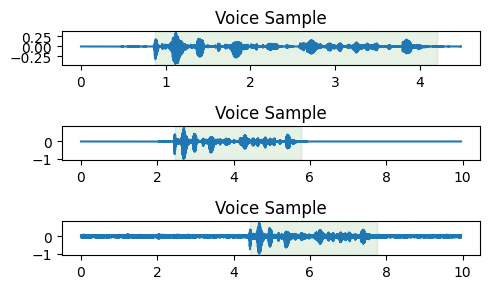

In [14]:
#Lädt Voice
voice, sr, info = file_dataset_voice_train[8]
ground_truth    = get_voice_word2vec(voice,sr,info)

#Lädt Noise
noise, sr, _    = file_dataset_background_noise_train[1]

#SampleGenerator
sg = SampleGenerator()
x_1, y_1 = sg(voice, None,  ground_truth)
x_2, y_2 = sg(voice, noise, ground_truth)

#Plot
fig = plt.figure(figsize=(5, 3))

#Voice
ax = plt.subplot2grid((3, 1), (0, 0), fig=fig)
plot.plot_waveform_with_voice(voice, ground_truth, sr = SAMPLE_RATE, ax=ax)
ax.set_title(f"Voice Sample")
ax.set_xlabel("")
ax.set_ylabel("")

ax = plt.subplot2grid((3, 1), (1, 0), fig=fig)
plot.plot_waveform_with_voice(x_1, y_1, sr = SAMPLE_RATE, ax=ax)
ax.set_title(f"Voice Sample")
ax.set_xlabel("")
ax.set_ylabel("")

ax = plt.subplot2grid((3, 1), (2, 0), fig=fig)
plot.plot_waveform_with_voice(x_2, y_2, sr = SAMPLE_RATE, ax=ax)
ax.set_title(f"Voice Sample")
ax.set_xlabel("")
ax.set_ylabel("")

#Layout
fig.tight_layout()

In [15]:
#Layert Sample mit anderem Sound
class LayeredSoundGenerator (nn.Module):
    
    def __init__(
            self,
            ratio_db = 12
        ):
            super().__init__()
            
            #Params
            self.ratio_db = ratio_db

            #Variables
            self.normalize_result = True
    

    @torch.no_grad()
    def forward(self, sample, layer, repeat=False):
        
        #Fixt überschreiben des ursrpünglichen Tensors
        sample = torch.clone(sample)
        layer  = torch.clone(layer)

        #Skaliert Layer
        peak_db_layer = db(sample.abs().max()) - self.ratio_db
        layer = normalize_waveform_to_peak(layer,  peak = peak_db_layer)

        #Layered wird Wiederholt
        if repeat:
            _repeats  = ( sample.size(-1) // layer.size(-1) ) + 2 #Plus 2 sorgt dafür das irgendwo im Sample angefangen und wiede aufegöhrt werden kann
            layer     = layer.repeat(_repeats)
            start_idx = torch.randint(low=0, high=layer.size(-1) - sample.size(-1), size=(1,))
            layer     = layer[ start_idx : start_idx + sample.size(-1) ]
        
        #ohne Repeat
        else:
            if layer.size(-1) < sample.size(-1):
                padding = torch.zeros(size = (sample.size(-1) - layer.size(-1),) )
                layer = torch.concat([layer, padding])
                layer = layer.roll( shifts = torch.randint(low=0, high=sample.size(-1), size=(1,)).item() )
            
            elif layer.size(-1) > sample.size(-1):
                start_idx = torch.randint(low=0, high=layer.size(-1) - sample.size(-1), size=(1,))
                layer     = layer[ start_idx : start_idx + sample.size(-1) ]

        #Fügt Noise Sample hinzu
        sample += layer

        #Normalisiert Ergebnis
        if self.normalize_result:
            sample = normalize_waveform_to_peak(sample)

        return sample

#Layert Sample mit Sound aus einem Dataset
class RandomLayeredSoundGenerator(nn.Module):
    
    def __init__(
            self,
            file_dataset,
            layer_chain             = None,
            layered_sound_generator = LayeredSoundGenerator(),
        ):
            super().__init__()

            self.layered_sound_generator = layered_sound_generator
            self.file_dataset            = file_dataset
            self.layer_chain             = layer_chain

    @torch.no_grad()
    def forward(self, sample):

        #Lädt ein zufälliges Sample
        layer_idx   = np.random.randint(0, len(self.file_dataset)) 
        layer, _, _ = self.file_dataset[layer_idx]

        #Effect Chain
        if self.layer_chain is not None:
            layer = self.layer_chain(layer)

        return self.layered_sound_generator(sample, layer, repeat=random.choice([True, False]))


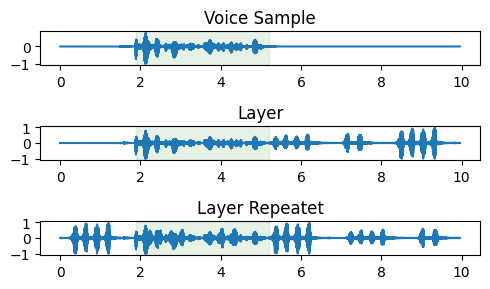

In [16]:
#Lädt Voice
voice, sr, info = file_dataset_voice_train[8]
ground_truth    = get_voice_word2vec(voice,sr,info)

#Lädt Layer
layer, sr, _ = file_dataset_layer_noises_train[0]

#SampleGenerator
sg = SampleGenerator()
x, y = sg(voice, None,  ground_truth)

#LayeredSoundGenerator
lsg = LayeredSoundGenerator(0)
x_2 = lsg(x, layer, repeat=False)
x_3 = lsg(x, layer, repeat=True)

#Plot
fig = plt.figure(figsize=(5, 3))

#Normal
ax = plt.subplot2grid((3, 1), (0, 0), fig=fig)
plot.plot_waveform_with_voice(x, y, sr = SAMPLE_RATE, ax=ax)
ax.set_title(f"Voice Sample")
ax.set_xlabel("")
ax.set_ylabel("")

ax = plt.subplot2grid((3, 1), (1, 0), fig=fig)
plot.plot_waveform_with_voice(x_2, y, sr = SAMPLE_RATE, ax=ax)
ax.set_title(f"Layer")
ax.set_xlabel("")
ax.set_ylabel("")

ax = plt.subplot2grid((3, 1), (2, 0), fig=fig)
plot.plot_waveform_with_voice(x_3, y, sr = SAMPLE_RATE, ax=ax)
ax.set_title(f"Layer Repeatet")
ax.set_xlabel("")
ax.set_ylabel("")

#Layout
fig.tight_layout()

In [17]:
class RandomModuleSelector(nn.Module):
    def __init__(self, modules) -> None:
        super().__init__()

        #Params
        self.modules = modules
    
    @torch.no_grad()
    def forward(self, *args, **kwargs):
        return random.choice( self.modules )(*args, **kwargs)

class ProbablityModuleSelector(nn.Module):
    def __init__(self, module, probability = 0.75) -> None:
        super().__init__()
        self.probability = probability
        self.module      = module
    
    @torch.no_grad()
    def forward(self, waveform, *args, **kwargs):
        
        #Führt Modul ggf aus 
        if np.random.uniform() <= self.probability:
            return self.module(waveform, *args, **kwargs)
        
        return waveform

In [18]:
#Checkt ob Waveform Inhalt hat
def check_signal_for_content(waveform = None):
    
    #Bedingungen
    check_for_gt0 = waveform.abs().max() < 1e-6
    check_for_inf = bool(torch.sum(torch.isinf(waveform)))
    check_for_nan = bool(torch.sum(torch.isnan(waveform)))
    
    #Raise Exception
    if check_for_gt0 or check_for_inf or check_for_nan:
        return False
    
    #Returnt True
    return True

In [19]:
#Layered Voice mit Noise
class SpeakDataset(Dataset):
    def __init__(self,  voice_dataset, noise_dataset, sample_generator, sample_chain, ground_truth_extractor) -> None:
        super().__init__()
        
        #Switcht für Noise
        self.add_noise = True

        #Parameter
        self.sample_generator       = sample_generator
        self.sample_chain           = sample_chain
        self.ground_truth_extractor = ground_truth_extractor

        #Datasets
        self.voice_dataset = voice_dataset
        self.noise_dataset = noise_dataset
    
    def __len__(self):
            return len(self.voice_dataset)

    @torch.no_grad()
    def __getitem__(self, voice_idx):
        
        #Lädt Samples
        voice, sr, info = self.voice_dataset[voice_idx]
        if not check_signal_for_content (voice):
            raise Exception(f"VOICE-Sample {voice_idx} ist fehlerhaft")
        
        #Erzeugt voice_ground_truth
        voice_ground_truth = self.ground_truth_extractor(voice, sr, info)
        
        #Noise
        noise     = None
        noise_idx = None
        
        #Generiert Noise
        if self.add_noise:
            noise_idx   = np.random.randint(0, len(self.noise_dataset)) 
            noise, _, _ = self.noise_dataset[noise_idx]
            if not check_signal_for_content (noise):
                raise Exception(f"NOISE-Sample {noise_idx} ist fehlerhaft")

        #Layert Sample mit Noise
        waveform, voice_ground_truth = self.sample_generator(voice, noise, voice_ground_truth)

        #Führt FX aus
        if self.sample_chain:
            waveform = self.sample_chain(waveform)
        
        #Checkt Output
        if not (check_signal_for_content (waveform) and check_signal_for_content(voice_ground_truth)):
            raise Exception(f"Ergebnis bestehend aus VOICE-Sample {voice_idx} und NOISE-Sample {noise_idx} ist fehlerhaft")

        #Returnt Sample
        return waveform, voice_ground_truth

In [20]:
#Ground Truth Extraktor
train_ground_truth_extractor = get_voice_word2vec
test_ground_truth_extractor  = get_voice_labeld

#Erzeugt Sample
sample_generator = RandomModuleSelector(modules=[
    SampleGenerator(sn_ratio_db=0),
    SampleGenerator(sn_ratio_db=6),
    SampleGenerator(sn_ratio_db=12),
    SampleGenerator(sn_ratio_db=30),
])

#Layered Sample TRAIN
sample_chain_train = nn.Sequential(
    ProbablityModuleSelector(
        probability = 0.75,
        module = RandomModuleSelector(modules=[
            RandomLayeredSoundGenerator(file_dataset_layer_noises_train, layered_sound_generator = LayeredSoundGenerator(ratio_db=0)),
            RandomLayeredSoundGenerator(file_dataset_layer_noises_train, layered_sound_generator = LayeredSoundGenerator(ratio_db=6)),
            RandomLayeredSoundGenerator(file_dataset_layer_noises_train, layered_sound_generator = LayeredSoundGenerator(ratio_db=12)),
            RandomLayeredSoundGenerator(file_dataset_layer_noises_train, layered_sound_generator = LayeredSoundGenerator(ratio_db=30)),
        ])
    )
)

#Layered Sample TEST
sample_chain_test = nn.Sequential(
    ProbablityModuleSelector(
        probability = 0.75,
        module = RandomModuleSelector(modules=[
            RandomLayeredSoundGenerator(file_dataset_layer_noises_test, layered_sound_generator = LayeredSoundGenerator(ratio_db=0)),
            RandomLayeredSoundGenerator(file_dataset_layer_noises_test, layered_sound_generator = LayeredSoundGenerator(ratio_db=6)),
            RandomLayeredSoundGenerator(file_dataset_layer_noises_test, layered_sound_generator = LayeredSoundGenerator(ratio_db=12)),
            RandomLayeredSoundGenerator(file_dataset_layer_noises_test, layered_sound_generator = LayeredSoundGenerator(ratio_db=30)),
        ])
    )
)

#SpeakDataset
speak_dataset_train = SpeakDataset(file_dataset_voice_train, file_dataset_background_noise_train, sample_generator, sample_chain_train, train_ground_truth_extractor)
speak_dataset_test  = SpeakDataset(file_dataset_voice_test,  file_dataset_background_noise_trest, sample_generator, sample_chain_test,  test_ground_truth_extractor)

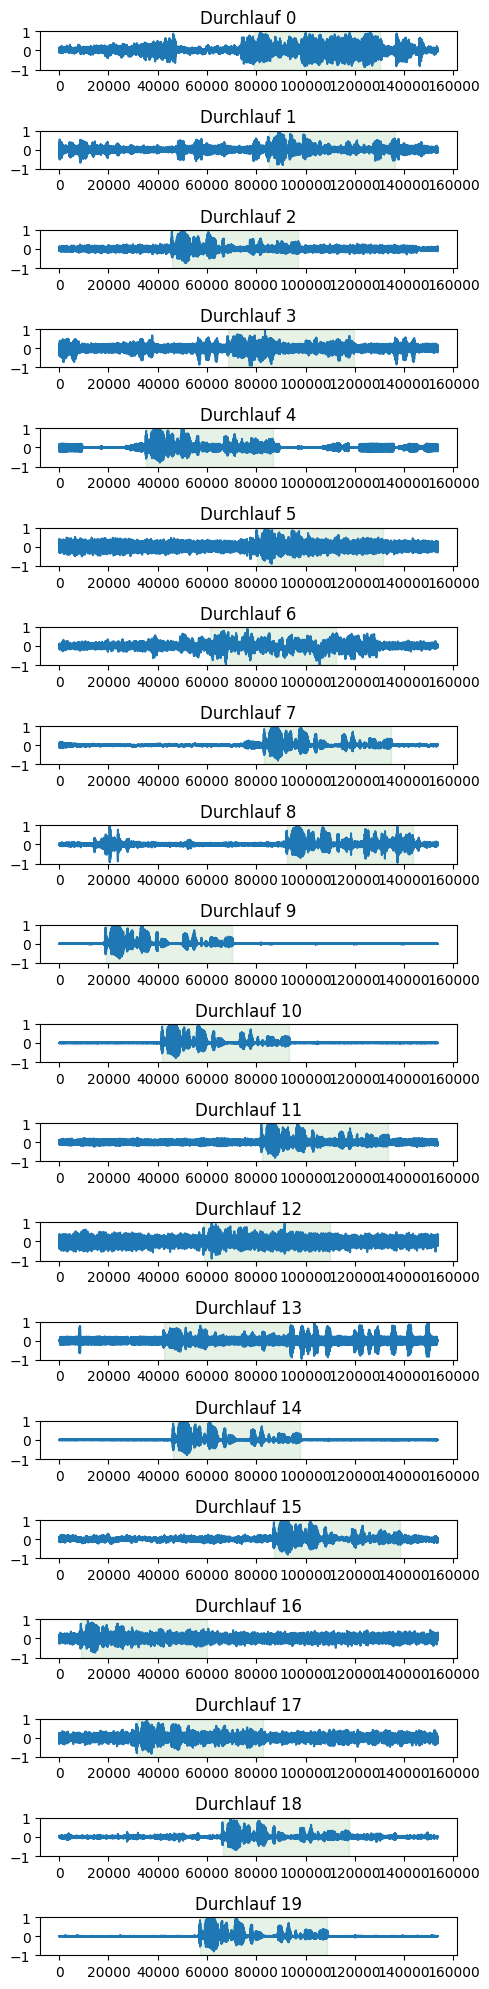

In [21]:
#Background Noises
_num_plots = 20
_plot_idx  = 0

#Plot
fig = plt.figure(figsize=(5, _num_plots))

#Iterriert
for i in range(_num_plots):
    
    #Lädt Sample
    x, y, = speak_dataset_train[ _plot_idx ]

    #Plottet
    ax = plt.subplot2grid((_num_plots, 1), (i, 0), fig=fig)
    plot.plot_waveform_with_voice(x, y, ax=ax, y_axis_0dbfs_scale=True)

    ax.set_title(f"Durchlauf {i}")
    ax.set_xlabel("")
    ax.set_ylabel("")

#Plot
fig.tight_layout()

In [22]:
#SAVE CSV
EXPORT_EVERY_SAMPLES = 1000

#PARAMETER
#dataset        = speak_dataset_test
#out_per_sample = 10
#out_path       = r"../data/SAMPLES GENERATED TEST"
#csv_name       = r"test.csv"

#PARAMETER
dataset        = speak_dataset_train
out_per_sample = 5
out_path       = r"/mnt/data/source_jonas/Samples/DATA/TRAIN"
csv_path       = r"/mnt/data/source_jonas/Samples/DATA/train.csv"

#Löscht Pfad
if os.path.exists(out_path):
    shutil.rmtree(out_path)

#Löscht CSV
if os.path.exists(csv_path):
    os.remove(csv_path)

#Erstellt Pfad
os.mkdir(out_path)

#Ergebnis
result = []

#Iterriert über Dataset
for idx in tqdm(range(len(dataset))):
    
    #Iterriert Anzahl der Samples für Out
    for run in range(out_per_sample):
        
        #Lädt Sample
        x,y = dataset[idx]

        #Erzeugt Name
        filename = f"{idx}_{run}.wav"

        #Out
        sf.write(file = os.path.join(out_path,filename), data = x, samplerate=SAMPLE_RATE)

        #Y
        nonzero = y.nonzero().flatten()
        start = nonzero.min().item()
        end   = nonzero.max().item()

        #Fügt Zeile an
        result.append({
            "filename" : filename,
            "start"    : start,
            "end"      : end
        })

    #Export aller 100 Samples
    if idx % EXPORT_EVERY_SAMPLES == 0:
        pd.DataFrame(result).to_csv(csv_path, index=False)

#Ergebnis -> csv
pd.DataFrame(result).to_csv(csv_path, index=False)

 37%|███▋      | 21418/57936 [11:26<22:35, 26.95it/s]